In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime

In [ ]:
def parser(x):
	return datetime.strptime(x, '%Y-%m')

In [ ]:
example = parser('1995-01')

example

datetime.datetime(1995, 1, 1, 0, 0)

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/Datasets/sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=False, date_parser=parser)

dataset.head()

# Output berbentuk Series, bukan DataFrame (karena nilai squeeze=True)

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


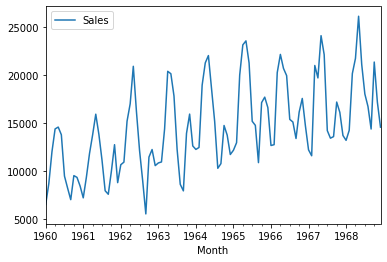

In [ ]:
dataset.plot()
plt.show()

**dari plot diatas dapat dilihat terdapat sebuah pola / trend dan seasonality dari data sales.csv**

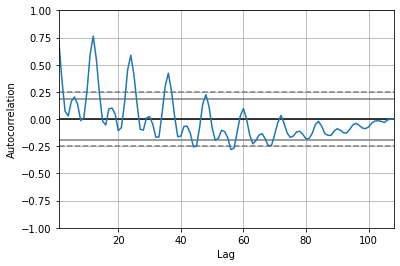

In [ ]:
pd.plotting.autocorrelation_plot(dataset)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
model = ARIMA(dataset, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  107
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -999.662
Method:                       css-mle   S.D. of innovations           2746.033
Date:                Fri, 18 Sep 2020   AIC                           2013.324
Time:                        05:52:19   BIC                           2032.033
Sample:                    02-01-1960   HQIC                          2020.908
                         - 12-01-1968                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            49.4520    191.309      0.258      0.797    -325.506     424.410
ar.L1.D.Sales     0.0558      0.095      0.587      0.559      -0.131       0.242
ar.L2.D.Sales     0.0026      0.093     

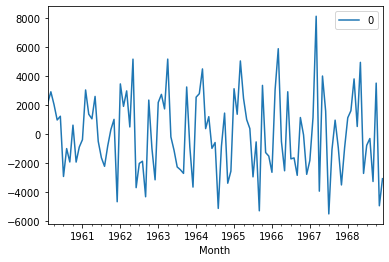

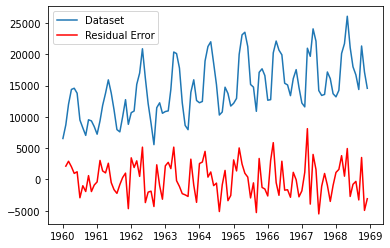

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

plt.plot(dataset)
plt.plot(residuals,  color='red')
plt.legend(['Dataset','Residual Error'])

In [ ]:
values = dataset.values
size = int(len(values) * 0.66) #0.66 persesan training set
train, test = values[0:size], values[size:len(values)]
history = [x for x in train]
predictions = []

model = AR(train)
model_fit = model.fit()
print('Lag:', model_fit.k_ar)

Lag: 11


In [ ]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	prediction = output[0]
	predictions.append(prediction)
	expected = test[t]
	history.append(expected)
	print('predicted=%f, expected=%f' % (prediction, expected))
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)

predicted=19178.213329, expected=16611.000000
predicted=14810.726195, expected=12674.000000
predicted=9933.264818, expected=12760.000000
predicted=13950.935600, expected=20249.000000
predicted=23834.156970, expected=22135.000000
predicted=23110.934931, expected=20677.000000
predicted=16702.380601, expected=19933.000000
predicted=18005.129132, expected=15388.000000
predicted=16162.623043, expected=15113.000000
predicted=16232.058750, expected=13401.000000
predicted=15013.433230, expected=16135.000000
predicted=17604.531487, expected=17562.000000
predicted=18006.947396, expected=14720.000000
predicted=13579.679006, expected=12225.000000
predicted=10613.242613, expected=11608.000000
predicted=12906.866003, expected=20985.000000
predicted=24445.752774, expected=19692.000000
predicted=19682.120832, expected=24081.000000
predicted=20224.841741, expected=22114.000000
predicted=20717.052380, expected=14220.000000
predicted=13889.497696, expected=13434.000000
predicted=13119.099193, expected=13

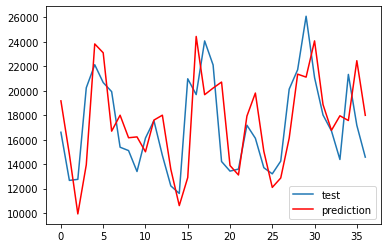

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['test','prediction'])
plt.show()

In [ ]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order): #rolling forecast
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f ' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
import warnings

p_values = range(0, 10)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=23860228.841 
ARIMA(0, 0, 1) MSE=13871657.449 
ARIMA(0, 1, 0) MSE=13540638.651 
ARIMA(0, 1, 1) MSE=14145961.836 
ARIMA(0, 1, 2) MSE=15295213.974 
ARIMA(0, 2, 0) MSE=26660415.091 
ARIMA(0, 2, 1) MSE=13968678.182 
ARIMA(0, 2, 2) MSE=14572950.039 
ARIMA(1, 0, 0) MSE=11723714.919 
ARIMA(1, 0, 1) MSE=11799199.349 
ARIMA(1, 0, 2) MSE=11389772.766 
ARIMA(1, 1, 0) MSE=14164796.677 
ARIMA(1, 2, 0) MSE=22748049.598 
ARIMA(2, 0, 0) MSE=11999482.717 
ARIMA(2, 0, 2) MSE=12577205.672 
ARIMA(2, 1, 0) MSE=14304001.910 
ARIMA(2, 2, 0) MSE=22715347.083 
ARIMA(3, 0, 0) MSE=12128041.398 
ARIMA(3, 1, 0) MSE=12696217.431 
ARIMA(3, 2, 0) MSE=22046767.134 
ARIMA(4, 0, 0) MSE=11631872.296 
ARIMA(4, 1, 0) MSE=11387047.158 
ARIMA(4, 2, 0) MSE=13540691.644 
ARIMA(5, 0, 0) MSE=10954906.697 
ARIMA(5, 1, 0) MSE=10778314.679 
ARIMA(5, 2, 0) MSE=13784962.027 
ARIMA(6, 0, 0) MSE=9993852.857 
ARIMA(6, 1, 0) MSE=10818990.892 
ARIMA(6, 2, 0) MSE=13578512.676 
ARIMA(7, 0, 0) MSE=10411833.033 
ARIMA(7, 1,

Untuk dataset ini menggunakan **ARIMA** didapatkan hasil terbaik nya dengan **MSE = 9503244.126**. dengan nilai parameter berikut :
**p = 9** yaitu lag order yang digunakan 9 (data yang dilihat berdasarkan 9 data waktu sebelumnya)
**d = 0** yaitu nilai yang digunakan untuk membuat data stationary .
**q = 0 **yaitu menggabungkan ketergantungan antara observasi dan nilai residual dari model moving average yang diterapkan pada nilai lag yang diamati

In [ ]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [9]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [ ]:
n_test = 12

# model configs
cfg_list = sarima_configs()

# grid search
scores = grid_search(dataset.values, cfg_list, n_test)
print('done')

# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

 > Model[[(9, 0, 0), (0, 0, 0, 0), 'n']] 2630.908
 > Model[[(9, 0, 0), (0, 0, 1, 0), 'n']] 2913.292
 > Model[[(9, 0, 0), (0, 0, 2, 0), 'n']] 2985.164
 > Model[[(9, 0, 0), (1, 0, 0, 0), 'n']] 2479.004
 > Model[[(9, 0, 0), (1, 0, 1, 0), 'n']] 1883.681
 > Model[[(9, 0, 0), (1, 0, 2, 0), 'n']] 1929.081
 > Model[[(9, 0, 0), (2, 0, 0, 0), 'n']] 1956.214
 > Model[[(9, 0, 0), (2, 0, 1, 0), 'n']] 1891.269
 > Model[[(9, 0, 0), (0, 0, 0, 0), 'c']] 2627.945
 > Model[[(9, 0, 0), (0, 0, 1, 0), 'c']] 2878.171
 > Model[[(9, 0, 0), (2, 0, 2, 0), 'n']] 2462.724
 > Model[[(9, 0, 0), (0, 0, 2, 0), 'c']] 2951.742
 > Model[[(9, 0, 0), (1, 0, 0, 0), 'c']] 2500.683
 > Model[[(9, 0, 0), (1, 0, 1, 0), 'c']] 2346.634
 > Model[[(9, 0, 0), (1, 0, 2, 0), 'c']] 2488.662
 > Model[[(9, 0, 0), (2, 0, 0, 0), 'c']] 2206.523
 > Model[[(9, 0, 0), (2, 0, 1, 0), 'c']] 2298.091
 > Model[[(9, 0, 0), (0, 0, 0, 0), 't']] 2672.953
 > Model[[(9, 0, 0), (2, 0, 2, 0), 'c']] 2386.740
 > Model[[(9, 0, 0), (0, 0, 1, 0), 't']] 2975.965


pada model SARIMA berdasarkan nilai RMSE didapatkan hasil terbaik ... dengan lag(**p**) bernilai 9, **d** bernilai 1, **q** bernilai 0 untuk autoregression.
sedangkan untuk seasonal nya dengan parameter **P** bernilai 2, dan **Q**, **D**, **m** bernilai 0
dari grafik dapat kita lihat bahwa terdapat Trend yang bernilai konstan dari waktu ke waktu, dan Seasonal namun kenaikan data nya relatif rendah


In [ ]:
rmse = sqrt(9503244.126)
rmse

3082.7332232939

Best ARIMA(9, 0, 0) MSE=9503244.126 RMSE = 3082.7332232939
Best SARIMA [(9, 1, 0), (2, 0, 0, 0), 't'] RMSE = 1411.9988033039253
berdasarkan hasil tersebut meskipun RMSE nya tinggi tetapi pada kasus kali ini SARIMA lebih baik karena bisa kita lihat pada diagram diawal data terbentuk sebuah trend dan seasonality, dengan begitu model SARIMA lebih cocok untuk data sales.csv ini
